In [1]:
import numpy as np
import pandas as pd
import os
import sys

# Add the directory containing the VotingModel to the Python path
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/'))
from model.VotingRules import mean_aggregation, median_aggregation, quadratic_aggregation

from model.VotingModel import VotingModel

In [32]:
def add_remove_projects(model, project_to_manipulate, voting_rule, add):
    original_allocation = model.allocate_funds(voting_rule)
    current_funds = original_allocation[project_to_manipulate]

    if add:
        # Add new projects and calculate the new allocation
        new_project = np.random.rand(model.num_voters, 1)
        new_project /= new_project.sum(axis=0, keepdims=True)  # Normalize
        model.voting_matrix = np.hstack((model.voting_matrix, new_project))
        new_allocation = model.allocate_funds(voting_rule)
        new_funds = new_allocation[project_to_manipulate]
    else:
        # Remove projects and calculate the new allocation
        remove_idx = np.random.choice(model.num_projects, 1)
        model.voting_matrix = np.delete(model.voting_matrix, remove_idx, axis=1)
        new_allocation = model.allocate_funds(voting_rule)
        new_funds = new_allocation[project_to_manipulate]

    budget = abs(new_funds - current_funds) * model.num_voters
    return budget, new_allocation

def add_remove_voters(model, project_to_manipulate, voting_rule, add):
    original_allocation = model.allocate_funds(voting_rule)
    current_funds = original_allocation[project_to_manipulate]

    if add:
        # Add new voters and calculate the new allocation
        new_voter = np.random.rand(1, model.num_projects)
        new_voter /= new_voter.sum(axis=1, keepdims=True)  # Normalize
        model.voting_matrix = np.vstack((model.voting_matrix, new_voter))
        new_allocation = model.allocate_funds(voting_rule)
        new_funds = new_allocation[project_to_manipulate]
    else:
        # Remove voters and calculate the new allocation
        remove_idx = np.random.choice(model.num_voters, 1)
        model.voting_matrix = np.delete(model.voting_matrix, remove_idx, axis=0)
        new_allocation = model.allocate_funds(voting_rule)
        new_funds = new_allocation[project_to_manipulate]

    budget = abs(new_funds - current_funds) * model.num_projects
    return budget, new_allocation


In [50]:
def simulate_control(model, num_rounds, control_functions, project_to_manipulate, voting_rules, *args):
    results = []
    for voting_rule in voting_rules:
        for _ in range(num_rounds):
            model.step()
            round_results = {'voting_rule': voting_rule}
            for control_name, control_function in control_functions.items():
                budget, new_allocation = control_function(model, project_to_manipulate, voting_rule)
                round_results[control_name] = budget
            results.append(round_results)
    return pd.DataFrame(results)

# Define control functions
control_functions = {
    "add_projects": lambda m, p, vr: add_remove_projects(m, p, vr, True),
    "remove_projects": lambda m, p, vr: add_remove_projects(m, p, vr, False),
    "add_voters": lambda m, p, vr: add_remove_voters(m, p, vr, True),
    "remove_voters": lambda m, p, vr: add_remove_voters(m, p, vr, False)
}

# Parameters for the simulation
voter_type = 'random_uniform_model'
num_voters = 144
num_projects = 600
total_op_tokens = 30e6
num_rounds = 100
behavior_model = "random_uniform_model"  # Can be "uniform", "rn", or "mallows"
dispersion = 0.1  # For Mallows model
project_to_manipulate = np.random.randint(num_projects)  # Select a random project
desired_increase = 1000  # Example desired increase in funds
voting_rules = ["mean", "median", "quadratic"]  # Voting rules to evaluate

# Initialize the model
model = VotingModel(voter_type=voter_type, num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)

# Simulate the control process
control_results = simulate_control(model, num_rounds, control_functions, project_to_manipulate, voting_rules, dispersion)

control_results


,voting_rule,add_projects,remove_projects,add_voters,remove_voters
0,mean,0.001513,3.554315e+05,0.002527,75787.365367
1,mean,0.001713,1.078658e+04,0.001617,244430.673559
2,mean,0.001566,1.743962e+06,0.000248,21036.948054
3,mean,0.001802,7.771273e+04,0.001261,28645.955842
4,mean,0.001565,9.966639e+03,0.006487,80046.070343
...,...,...,...,...,...
295,quadratic,4.838035,1.932767e+05,3.547277,160378.083366
296,quadratic,5.096242,5.541332e+05,16.445278,97007.218765
297,quadratic,4.700499,1.136289e+04,9.900398,54624.392832
298,quadratic,4.469143,1.166233e+04,14.808481,140070.257785


In [39]:
# Analyze the results
def analyze_results(df):
    analysis = df.groupby('voting_rule').describe().transpose()
    return analysis

analysis_results = analyze_results(control_results)
analysis_results

voting_rule                    mean        median     quadratic
add_projects    count  1.000000e+02  1.000000e+02  1.000000e+02
                mean   1.667272e-03  2.366416e-03  4.782580e+00
                std    1.424069e-04  2.893438e-04  2.183122e-01
                min    1.352090e-03  1.586829e-03  4.220861e+00
                25%    1.564404e-03  2.153803e-03  4.640146e+00
                50%    1.651571e-03  2.372758e-03  4.758871e+00
                75%    1.776630e-03  2.581061e-03  4.912767e+00
                max    1.956119e-03  3.062937e-03  5.465773e+00
remove_projects count  1.000000e+02  1.000000e+02  1.000000e+02
                mean   1.956636e+05  1.752109e+05  7.609221e+04
                std    3.756271e+05  4.071801e+05  1.735923e+05
                min    8.819977e+03  7.573328e+03  1.107681e+03
                25%    1.204817e+04  1.088821e+04  1.169845e+04
                50%    1.318152e+04  1.223545e+04  1.225957e+04
                75%    2.071553e+05  1.520894e+04  1.352365e+04
                max    1.779042e+06  1.932377e+06  1.076420e+06
add_voters      count  1.000000e+02  1.000000e+02  1.000000e+02
                mean   3.319203e-03  2.356157e+05  1.017984e+01
                std    1.983467e-03  2.853602e+05  7.466303e+00
                min    1.831708e-04  2.820117e+03  4.562372e-02
                25%    1.525128e-03  1.090423e+05  3.985207e+00
                50%    3.305613e-03  1.798642e+05  8.053706e+00
                75%    4.870267e-03  2.670271e+05  1.558505e+01
                max    7.185242e-03  2.188481e+06  3.108726e+01
remove_voters   count  1.000000e+02  1.000000e+02  1.000000e+02
                mean   1.627652e+05  2.896432e+05  7.923986e+04
                std    1.341891e+05  3.617273e+05  5.719589e+04
                min    1.910509e+03  3.761643e+03  5.644973e+01
                25%    6.890398e+04  6.513946e+04  3.304946e+04
                50%    1.419445e+05  1.690416e+05  7.419601e+04
                75%    1.913101e+05  3.887591e+05  1.108361e+05
                max    6.471892e+05  2.518563e+06  2.568046e+05

Resistance: The quadratic aggregation method shows higher resistance to adding projects but lower resistance to removing projects compared to mean and median aggregation methods. Median aggregation shows the highest resistance to removing projects and adding voters.
Costs: Removing projects and voters generally incurs higher costs than adding them, indicating greater resistance to these control strategies.
Variability: High standard deviations and max values indicate significant variability in the costs, suggesting that the effectiveness of control strategies can vary widely depending on specific scenarios.

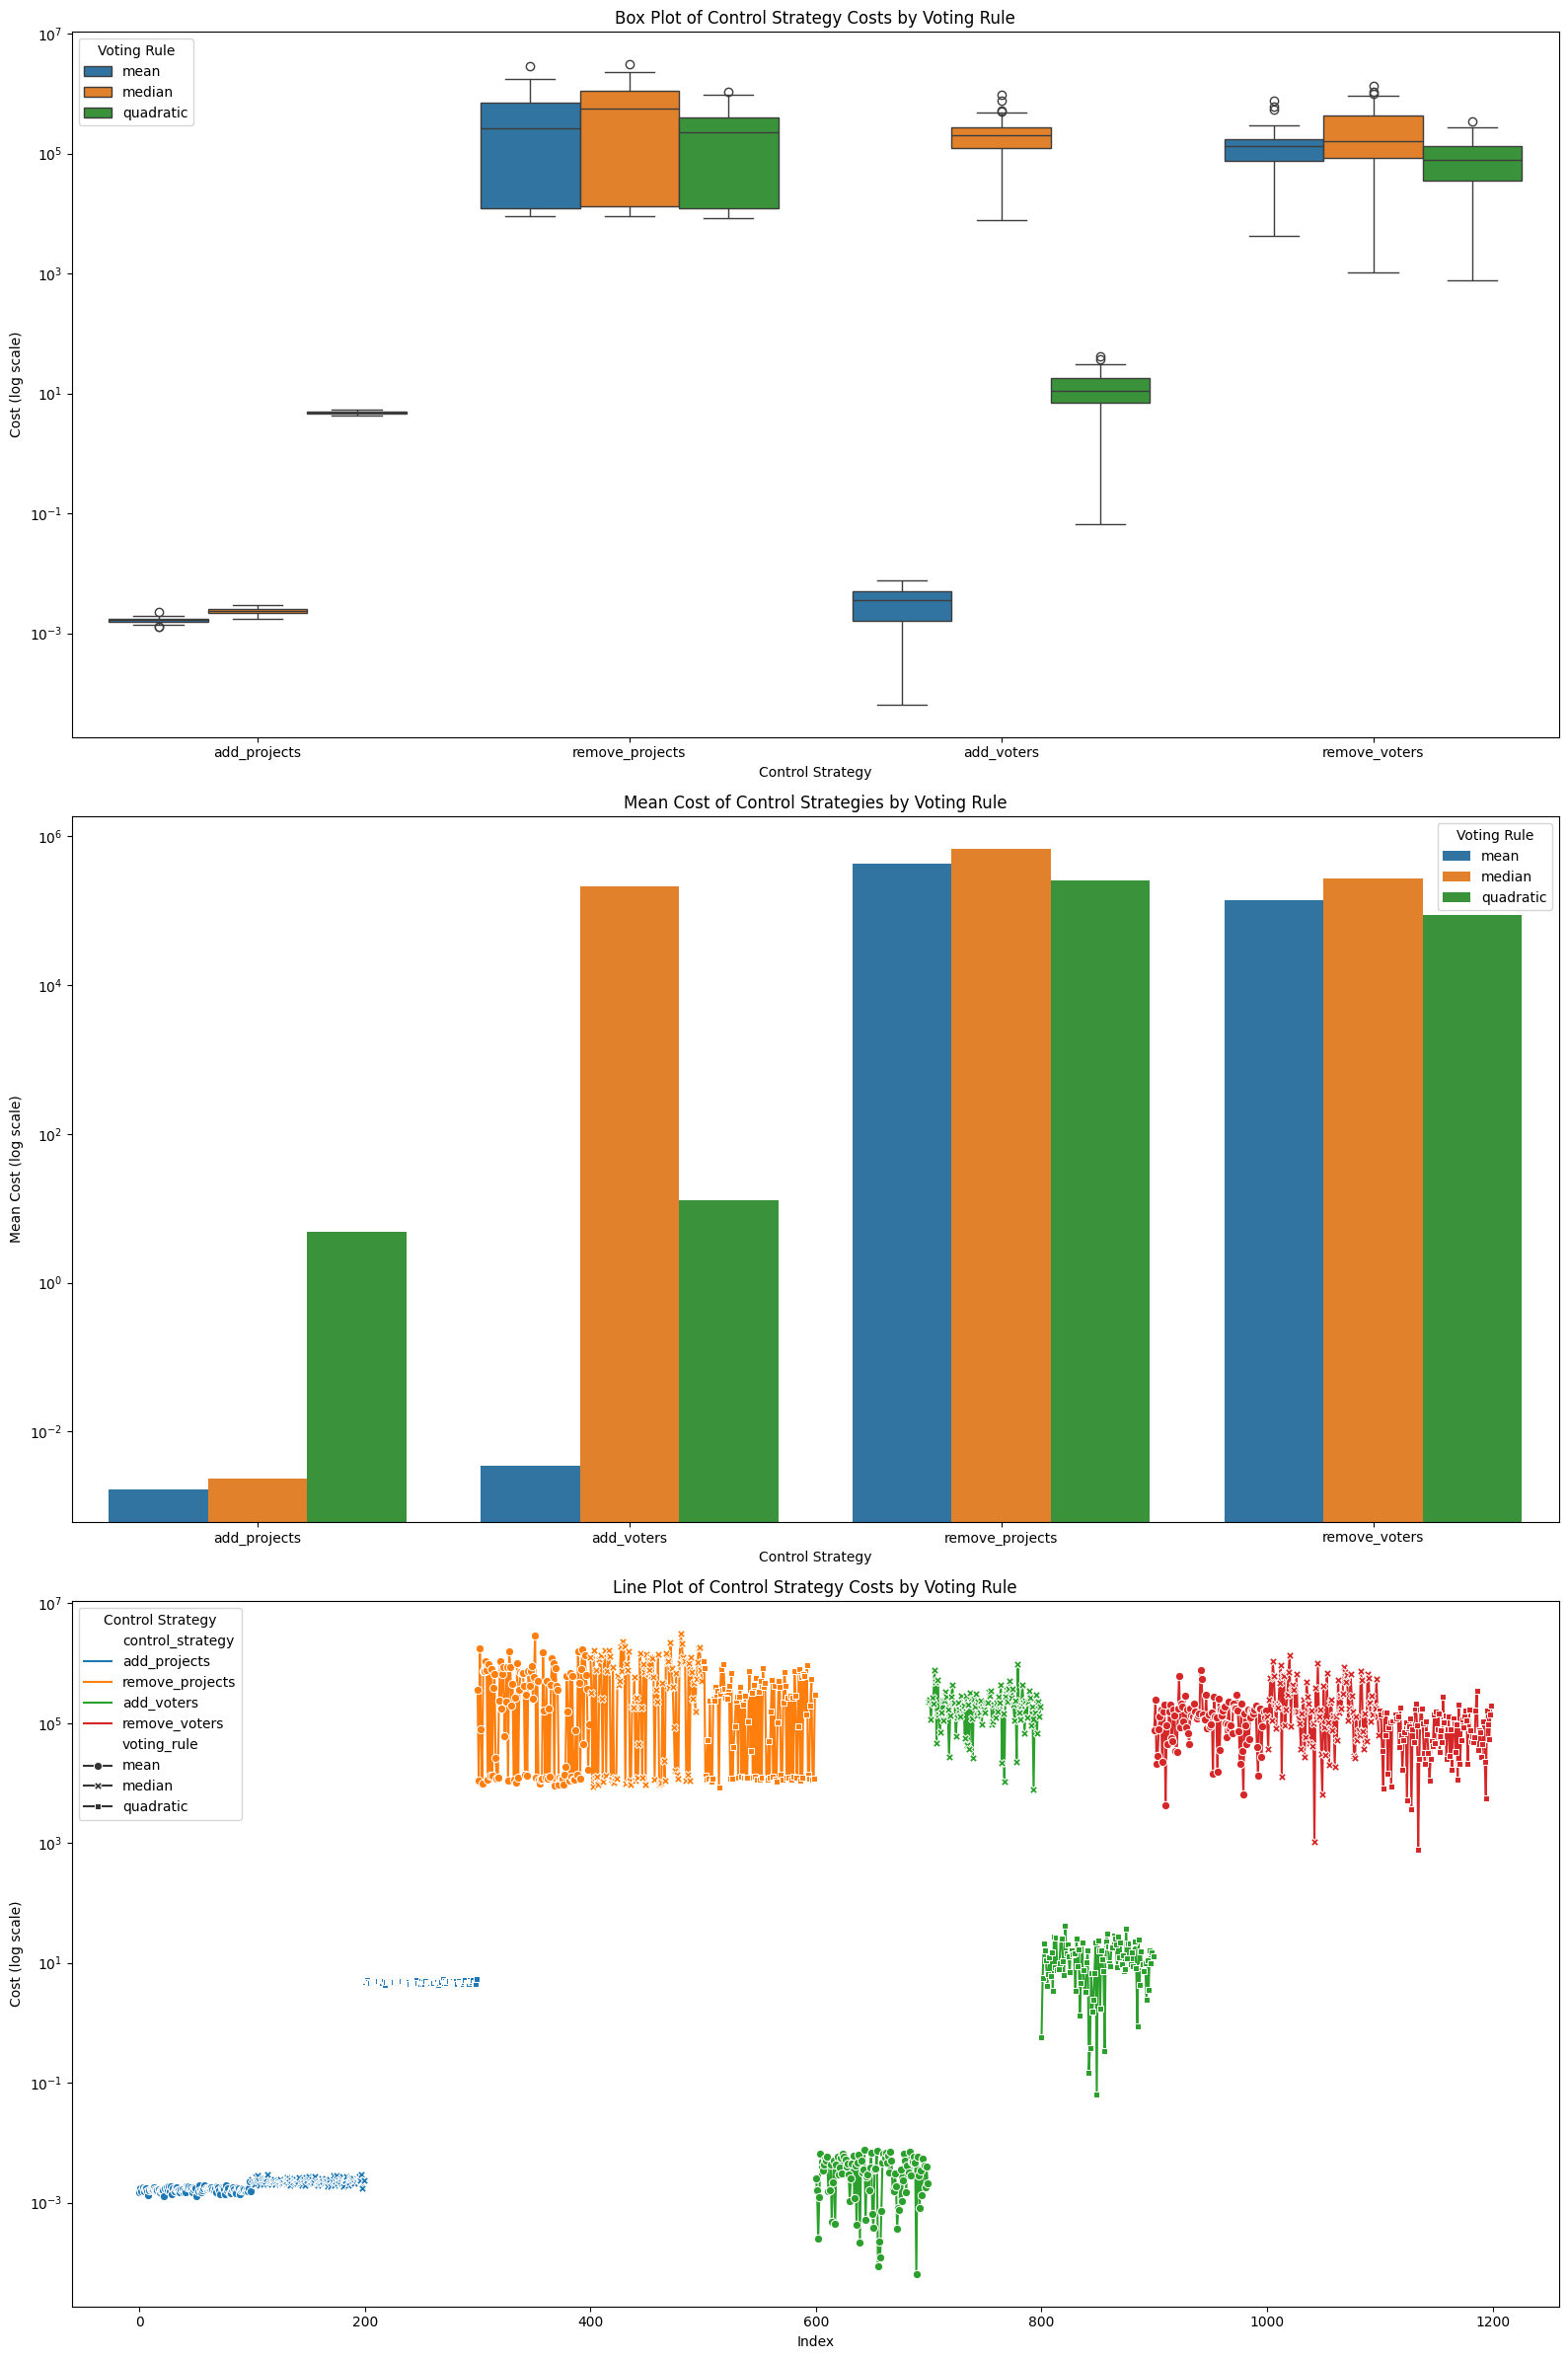

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `control_results_raw` is the DataFrame with the provided data

# Prepare data for plotting
control_results_long = control_results.melt(id_vars=['voting_rule'], var_name='control_strategy', value_name='cost')

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 24))

# Box Plot
sns.boxplot(x='control_strategy', y='cost', hue='voting_rule', data=control_results_long, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Box Plot of Control Strategy Costs by Voting Rule')
axes[0].set_xlabel('Control Strategy')
axes[0].set_ylabel('Cost (log scale)')
axes[0].legend(title='Voting Rule')

# Bar Plot for Mean Costs
mean_data = control_results_long.groupby(['control_strategy', 'voting_rule']).mean().reset_index()
sns.barplot(x='control_strategy', y='cost', hue='voting_rule', data=mean_data, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Mean Cost of Control Strategies by Voting Rule')
axes[1].set_xlabel('Control Strategy')
axes[1].set_ylabel('Mean Cost (log scale)')
axes[1].legend(title='Voting Rule')

# Line Plot for Individual Data Points
sns.lineplot(x='index', y='cost', hue='control_strategy', style='voting_rule', markers=True, dashes=False, data=control_results_long.reset_index(), ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_title('Line Plot of Control Strategy Costs by Voting Rule')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Cost (log scale)')
axes[2].legend(title='Control Strategy')

plt.tight_layout()
plt.show()


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_47862/1593928454.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='control_strategy', y='mean_cost', hue='voting_rule', data=mean_std_data, ax=axes[1], ci=None)


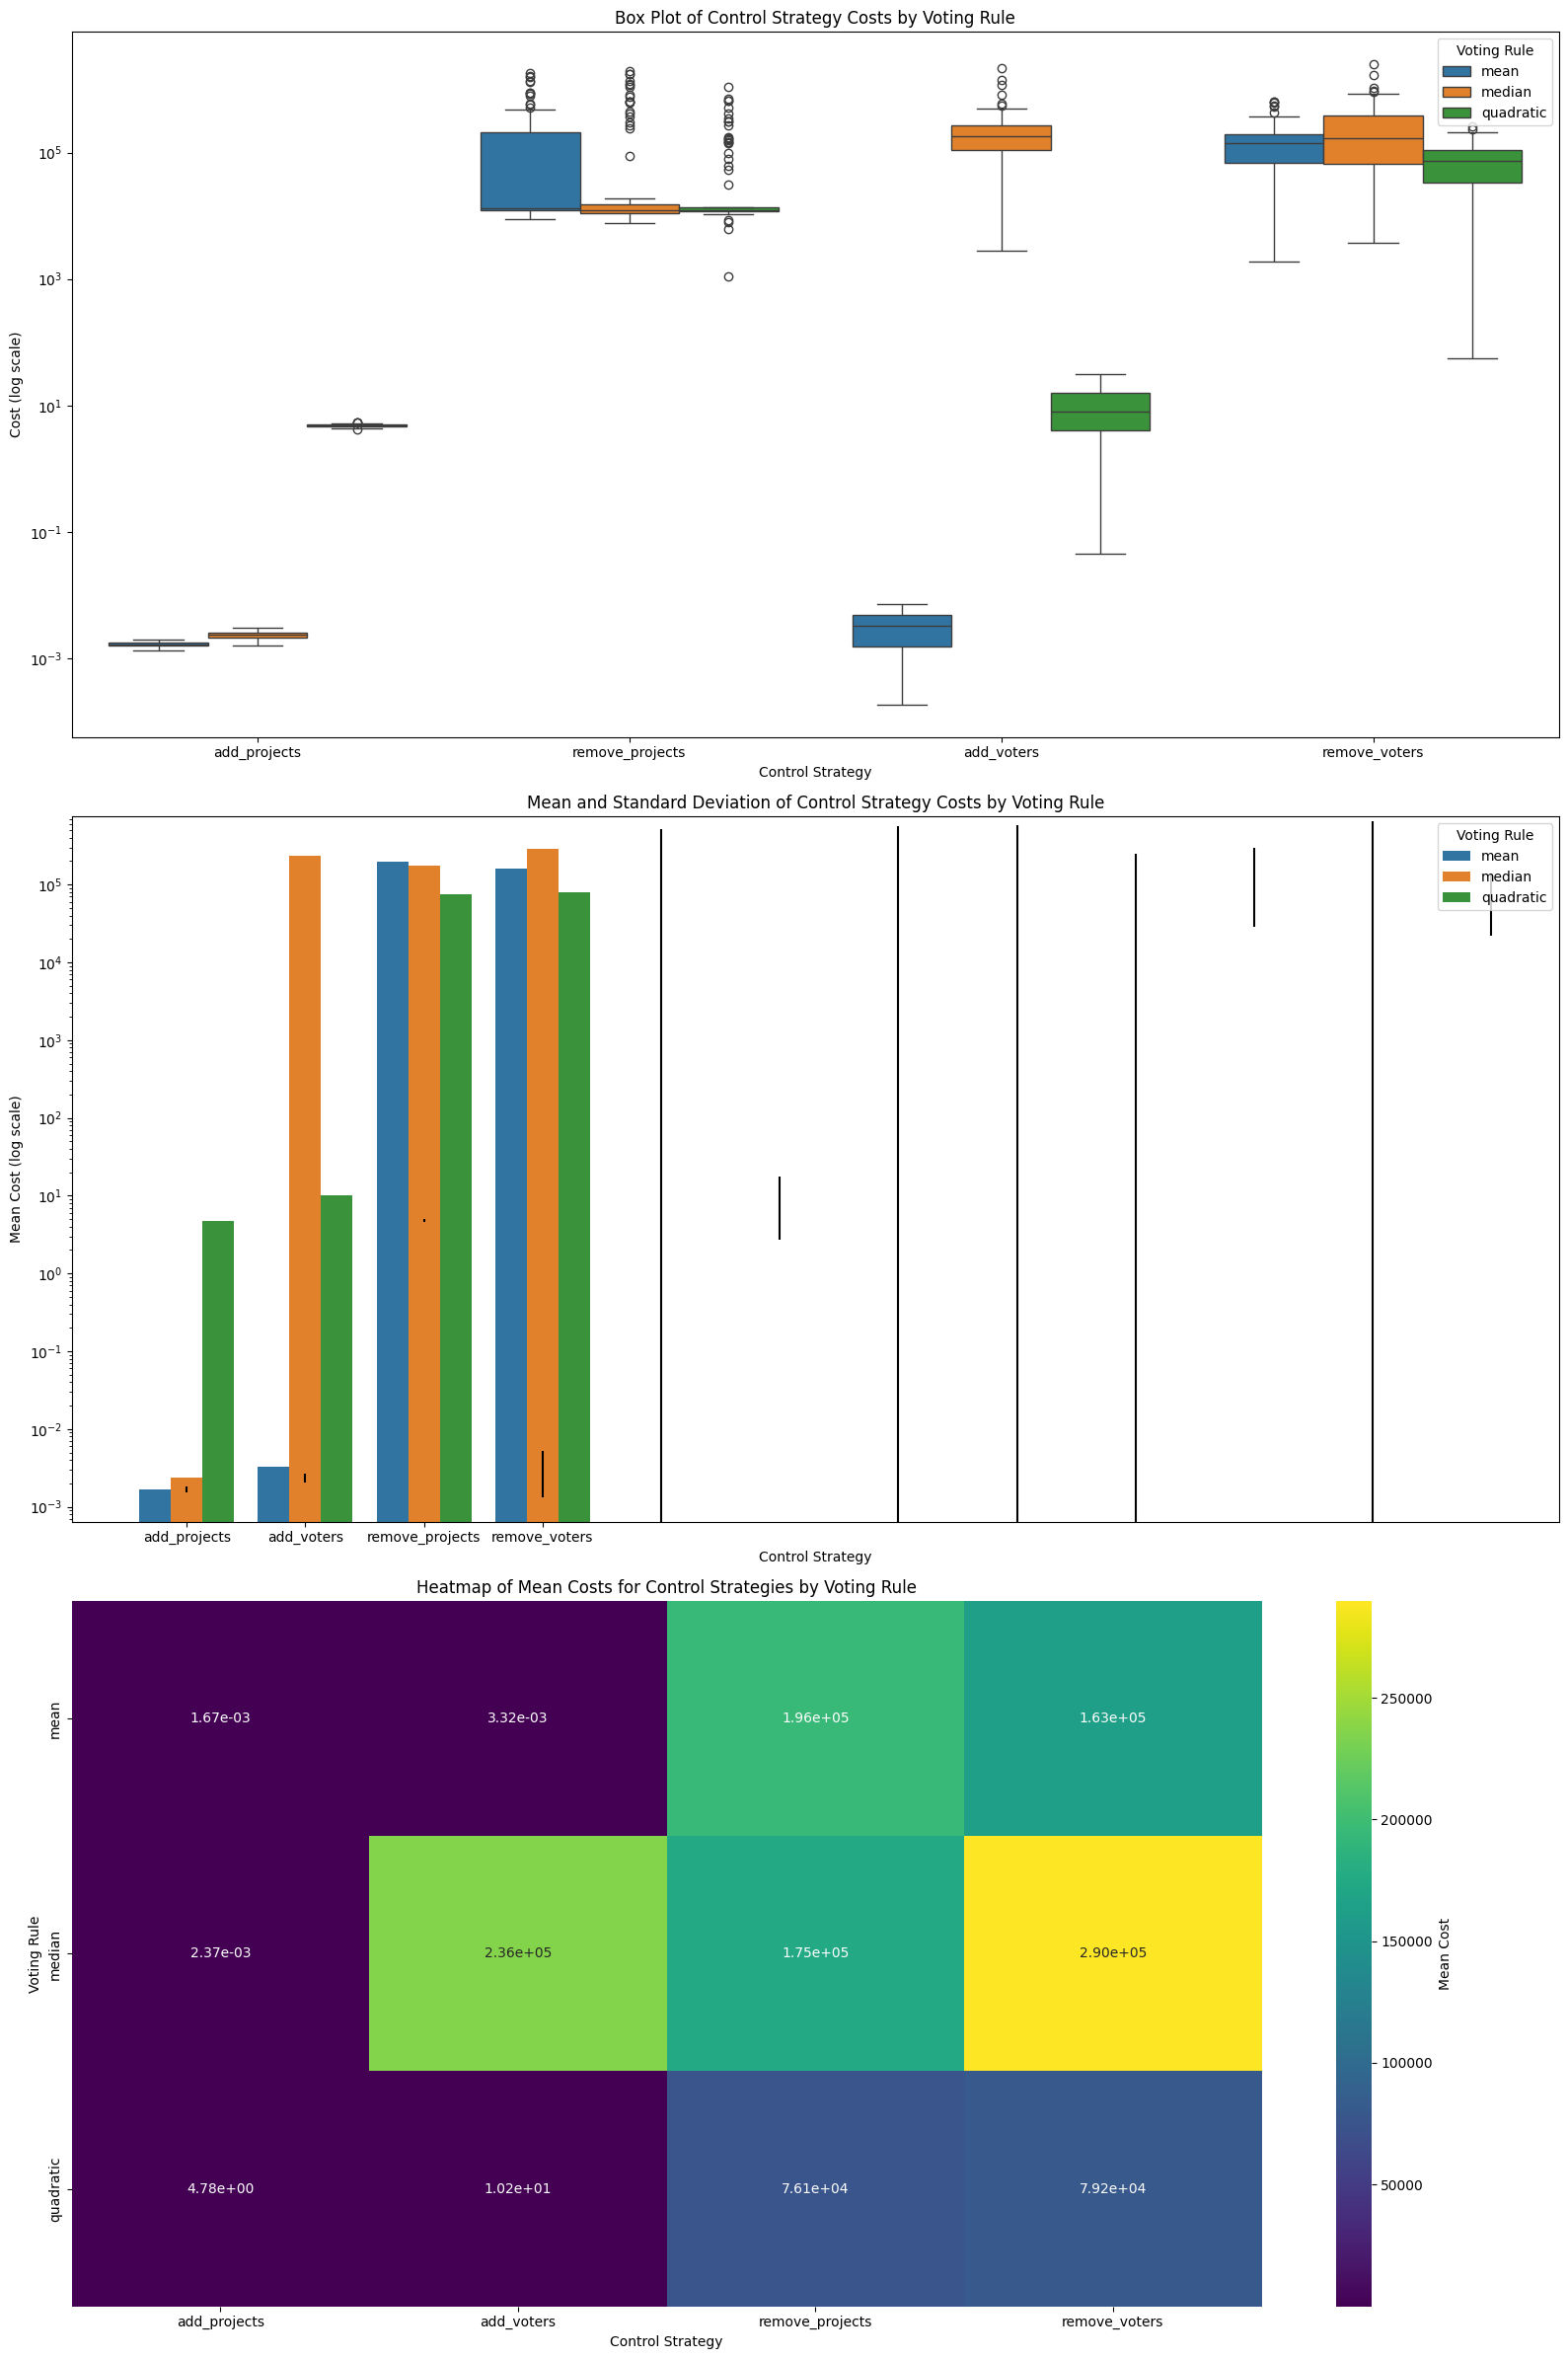

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparing data for enhanced visualization
control_results_long = control_results.melt(id_vars=['index', 'voting_rule'], var_name='control_strategy', value_name='cost')

# Creating a figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 24))

# Box Plot
sns.boxplot(x='control_strategy', y='cost', hue='voting_rule', data=control_results_long, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Box Plot of Control Strategy Costs by Voting Rule')
axes[0].set_xlabel('Control Strategy')
axes[0].set_ylabel('Cost (log scale)')
axes[0].legend(title='Voting Rule')

# Bar Plot for Mean and Standard Deviation
mean_std_data = control_results_long.groupby(['control_strategy', 'voting_rule']).agg(['mean', 'std']).reset_index()

# Flatten the MultiIndex
mean_std_data.columns = ['_'.join(col).strip() for col in mean_std_data.columns.values]
mean_std_data = mean_std_data.rename(columns={
    'control_strategy_': 'control_strategy', 
    'voting_rule_': 'voting_rule', 
    'cost_mean': 'mean_cost', 
    'cost_std': 'std_cost'
})

sns.barplot(x='control_strategy', y='mean_cost', hue='voting_rule', data=mean_std_data, ax=axes[1], ci=None)
axes[1].set_yscale('log')
for i, row in mean_std_data.iterrows():
    axes[1].errorbar(i, row['mean_cost'], yerr=row['std_cost'], fmt='none', c='black')
axes[1].set_title('Mean and Standard Deviation of Control Strategy Costs by Voting Rule')
axes[1].set_xlabel('Control Strategy')
axes[1].set_ylabel('Mean Cost (log scale)')
axes[1].legend(title='Voting Rule')

# Heatmap for Mean Costs
pivot_table = mean_std_data.pivot_table(index='voting_rule', columns='control_strategy', values='mean_cost')
sns.heatmap(pivot_table, annot=True, fmt=".2e", cmap='viridis', ax=axes[2], cbar_kws={'label': 'Mean Cost'})
axes[2].set_title('Heatmap of Mean Costs for Control Strategies by Voting Rule')
axes[2].set_xlabel('Control Strategy')
axes[2].set_ylabel('Voting Rule')

plt.tight_layout()
plt.show()
